# Using a Convolutional Downsampler with the Faster RCNN

In this Notebook, we try to put a few more convolutional layers in front of the backbone instead of simply resizing the image.

## Downloading the Dataset

Before doing this, you have to get your kaggle API key and your kaggle username and set it to the google colab secrets as "KAGGLE_USERNAME" and "KAGGLE_KEY".

In [ ]:
import os
from google.colab import userdata
import zipfile

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# This step needs to be done after the environment variables have been set, as it will raise an error, if it does not find the variables or a kaggle.json file
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download dataset
competition_name = 'global-wheat-detection'
api.competition_download_files(competition_name, path=os.getcwd())
print(f"Dataset '{competition_name}' downloaded successfully.")

extract_dir = "global_wheat_detection"

zip_file_path = "global-wheat-detection.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Successfully extracted '{zip_file_path}' to '{extract_dir}'.")

Dataset 'global-wheat-detection' downloaded successfully.
Successfully extracted 'global-wheat-detection.zip' to 'global_wheat_detection'.


## Dataset Class

I have used a dictionary because multiple bounding boxes may exist for every image. 

In [1]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import ast  # For safely evaluating the string representation of the list in bbox
from torchvision.transforms import functional as F
from torchvision import tv_tensors
import matplotlib.pyplot as plt

class BoundingBoxDataset(Dataset):
    def __init__(self, csv_file, dataset_dir, combined_transform=None, bbox_format='XYWH'):
        """
        This is a custom dataset class for bounding box data with only one class of objects to detect.
        Args:
            csv_file (str): Path to the CSV file containing bounding box annotations.
            dataset_dir (str): Path to the directory containing the images.
            combined_transform (callable, optional): Optional transform to be applied on a sample.
            bbox_format (str, optional): Format of the bounding boxes. Can be 'XYWH' or 'XYXY'.
        """
        self.csv_file = csv_file
        self.dataset_dir = dataset_dir
        self.combined_transform = combined_transform
        self.bbox_format = bbox_format

        # Load the CSV file into a DataFrame
        self.data = self.load_dataset_csv_as_dict(csv_file)
        self.add_missing_images()

        self.index_to_key, self.key_to_index = self.index_dictionary()

    def load_dataset_csv_as_dict(self, csv_file_path):
        # Read the CSV file
        df = pd.read_csv(csv_file_path, encoding="utf-8", sep=",", quotechar='"')

        # Initialize an empty dictionary to hold the dataset
        dataset_dict = {}

        # Group by 'image_id'
        grouped = df.groupby('image_id')

        for image_id, group in grouped:
            # Initialize the dictionary for this image
            image_data = {
                "width": group['width'].iloc[0],    # All rows for an image should have the same width
                "height": group['height'].iloc[0],  # Same for height
                "bboxes": [],
                "num_bboxes": len(group),
                "source": group['source'].iloc[0],  # Same for source
                "filepath": os.path.join(self.dataset_dir, f"{image_id}.jpg")       # Generate filename based on image_id
            }

            # Parse the 'bbox' column and collect bounding boxes
            for bbox_str in group['bbox']:
                bbox = ast.literal_eval(bbox_str)  # Convert the string representation of the list into a Python list
                image_data['bboxes'].append(bbox)

            # Add the image data to the dictionary
            dataset_dict[image_id] = image_data

        return dataset_dict

    def add_missing_images(self):
        all_files = os.listdir(self.dataset_dir)
        all_file_ids = [f.split(".")[0] for f in all_files]
        missing_file_ids = [f for f in all_file_ids if f not in self.data.keys()]

        for file_id in missing_file_ids:
            img_path = os.path.join(self.dataset_dir, f"{file_id}.jpg")
            if os.path.exists(img_path):
                # get height and width using PIL
                img = Image.open(img_path)
                width, height = img.size
                self.data[file_id] = {
                    "width": width,
                    "height": height,
                    "bboxes": [],
                    "num_bboxes": 0,
                    "source": "unknown",
                    "filepath": img_path
                }

    def index_dictionary(self):
        index_to_key = {}
        key_to_index = {}
        for i, key in enumerate(self.data.keys()):
            index_to_key[i] = key
            key_to_index[key] = i
        return index_to_key, key_to_index

    def __len__(self):
        # Return the number of unique image_ids in the dataset
        return len(self.data)


    def prepare_item(self, idx):
        # 1) Load image
        key = self.index_to_key[idx]
        img_path = self.data[key]['filepath']
        image = Image.open(img_path).convert("RGB")
        image = F.to_tensor(image)

        # 2) Load bounding boxes from self.data
        raw_bboxes = self.data[key].get('bboxes', None)
        if raw_bboxes is None or len(raw_bboxes) == 0:
            # No boxes => shape (0,4)
            bboxes = torch.empty((0, 4), dtype=torch.float32)
        else:
            # Possibly a list of shape Nx4, or [[], ...] in an edge case
            bboxes = torch.tensor(raw_bboxes, dtype=torch.float32)
            if bboxes.ndim == 2 and bboxes.shape[1] == 0:
                # shape is (N, 0) => interpret as truly empty
                bboxes = bboxes.view(0, 4)

        # 3) Convert to BoundingBoxes object
        #    Make sure 'bboxes' is Nx4 or 0x4:
        tv_tensor_boxes = tv_tensors.BoundingBoxes(
            bboxes,
            format="XYWH",
            canvas_size=image.shape  # [C, H, W]
        )

        # 4) Apply transforms if any
        if self.combined_transform:
            image, tv_tensor_boxes = self.combined_transform(image, tv_tensor_boxes)

        # 5) Return
        return image, tv_tensor_boxes


    def _xywh_to_xyxy(self, tensor):
        # tensor shape: (N, 4) in [x, y, w, h]
        if tensor.shape[0] == 0 or tensor.shape[1] == 0:    # weird stuff is happening with empty bounding boxes
            return tensor
        x_min = tensor[..., 0]
        y_min = tensor[..., 1]
        w = tensor[..., 2]
        h = tensor[..., 3]
        x_max = x_min + w
        y_max = y_min + h
        bboxes = torch.stack((x_min, y_min, x_max, y_max), dim=-1)
        return bboxes


    def __getitem__(self, idx):
        image, bboxes = self.prepare_item(idx)
        labels = torch.ones((bboxes.shape[0],), dtype=torch.long)

        # convert to different formats depending on the model requirements
        if self.bbox_format == 'XYWH':
            bboxes = tv_tensors.BoundingBoxes(bboxes, format="XYWH", canvas_size=image.shape)
        elif self.bbox_format == 'XYXY':
            bboxes = self._xywh_to_xyxy(bboxes)
        else:
            raise NotImplementedError("Only 'XYWH' and 'XYXY' format is supported for now.")

        target = {
            "boxes": bboxes,
            "labels": labels    # all labels are 1 because we have only one class
        }

        return image, target

    def show(self, key, mode='index', show_bboxes=True, transforms=False):
        if mode == 'index':
            idx = key
        elif mode == 'key':
            idx = self.key_to_index[key]
        else:
            raise ValueError("Invalid mode. Use 'index' or 'key'.")

        img, bboxes = self.prepare_item(idx)

        img = F.to_pil_image(img)

        plt.imshow(img)
        plt.axis('off')
        if show_bboxes:
            for bbox in bboxes:
                x, y, w, h = bbox
                rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
                plt.gca().add_patch(rect)
        plt.show()

## Custom Transforms, that augment Images and Bounding Boxes at the same time

In [2]:
import torch
from torchvision.transforms import v2
from torchvision import tv_tensors

class Random90DegreeRotation(torch.nn.Module):
    """
    Randomly rotates images and bounding boxes by 90, 180, or 270 degrees.
    """
    def __init__(self, format: str):
        super().__init__()
        self.format = format

    def forward(self, image, bboxes):
        """
        Rotates images and/or bounding boxes.

        Args:
            *inputs: One or more inputs (e.g., images, bounding boxes).

        Returns:
            tuple: Rotated inputs.
        """
        angle = torch.randint(0, 4, (1,)).item() * 90

        if angle == 0:  # No rotation needed
            return image, bboxes

        rotated_image = v2.functional.rotate(image, angle, expand=True)
        if not (bboxes.shape[0] == 0 or bboxes.shape[1] == 0):    # some weird stuff is happening
            bboxes = self.rotate_bboxes(bboxes, angle, image.size()[-2:])

        return rotated_image, bboxes


    def rotate_bboxes(self, bboxes, angle, canvas_size):
        """
        Rotate bounding boxes using torchvision.transforms.v2.

        Args:
            bboxes (tv_tensors.BoundingBoxes): Bounding boxes to rotate.
            angle (int): Angle in degrees (90, 180, 270).

        Returns:
            tv_tensors.BoundingBoxes: Rotated bounding boxes.
        """
        # Verify and fix canvas_size metadata
        if not hasattr(bboxes, "canvas_size") or len(bboxes.canvas_size) != 2:
            # Re-create BoundingBoxes with proper metadata
            bboxes = tv_tensors.BoundingBoxes(
                bboxes.data,  # Bounding box data (tensor)
                format=self.format, #bboxes.format,  # Original bounding box format
                canvas_size=canvas_size
            )

        # Rotate bounding boxes
        rotated_bboxes = v2.functional.rotate(
            bboxes,
            angle=angle,
            expand=True  # Allow canvas size to expand (not necessary here, as images are already square)
        )
        return rotated_bboxes


class RandomHorizontalBBoxFlip(torch.nn.Module):
    """
    Flips image and bboxes. Also handles empty bboxes.
    """
    def __init__(self, p: float, format: str):
        super().__init__()
        assert 0 < p <= 1
        self.p = p
        self.format = format

    def forward(self, image, bboxes):
        """
        Flips images and/or bounding boxes.

        Args:
            *inputs: One or more inputs (e.g., images, bounding boxes).

        Returns:
            tuple: Flipped inputs.
        """
        if torch.rand(1).item() < self.p:
            image = v2.functional.horizontal_flip(image)

            if not (bboxes.shape[0] == 0 or bboxes.shape[1] == 0):    # some weird stuff is happening
                # turn into tv_tensor bboxes
                bboxes = tv_tensors.BoundingBoxes(
                    bboxes.data,                        # Bounding box data (tensor)
                    format=self.format,                 # Original bounding box format
                    canvas_size=image.size()[-2:]
                )
                bboxes = v2.functional.horizontal_flip(bboxes)

        return image, bboxes


class RandomRGBGradient(torch.nn.Module):
    """
    Adds a random RGB color gradient to an image tensor.
    """
    def __init__(self, min_intensity: float, max_intensity: float, mode: str, p: float):
        super().__init__()
        assert 0 < p <= 1
        self.p = p
        self.min_intensity = min_intensity
        self.max_intensity = max_intensity
        self.mode = []
        if "R" in mode.upper():
            self.mode.append(0)
        if "G" in mode.upper():
            self.mode.append(1)
        if "B" in mode.upper():
            self.mode.append(2)

    def forward(self, image, bboxes):
        """
        Apply the gradient augmentation.

        Args:
            image (torch.Tensor): Input image tensor of shape (C, H, W).
            bboxes: Bounding boxes (passed through unmodified).

        Returns:
            tuple: Augmented image tensor and unmodified bounding boxes.
        """
        if torch.rand(1).item() > self.p:
            return image, bboxes
        if not isinstance(image, torch.Tensor):
            raise TypeError("Input must be a torch.Tensor")

        if image.dim() != 3 or image.size(0) != 3:
            raise ValueError("Input must be an RGB image tensor of shape (C, H, W)")

        _, h, w = image.shape
        max_dim = max(h, w)

        # Generate random angle and intensity
        angle = torch.rand(1).item() * 360  # Random angle in degrees
        intensity = torch.empty(1).uniform_(self.min_intensity, self.max_intensity).item()

        # Create a larger tensor for the gradient
        gradient_size = int(1.5 * max_dim)
        gradient = self._generate_gradient(gradient_size, intensity)

        # Rotate the gradient
        gradient_rotated = v2.functional.rotate(gradient, angle=angle, expand=True, interpolation=v2.InterpolationMode.BILINEAR)

        # Center crop the rotated gradient to the original image size
        gradient_cropped = v2.functional.center_crop(gradient_rotated, [h, w])

        # Set channels not in mode to 0
        for i in range(3):
            if i not in self.mode:
                gradient_cropped[i, :, :] = 0

        # Add the gradient to the image tensor
        augmented_image = image + gradient_cropped

        # Clamp the values to avoid overflow or underflow
        augmented_image = torch.clamp(augmented_image, 0, 1)

        return augmented_image, bboxes

    def _generate_gradient(self, size: int, intensity: float):
        """
        Generate a smooth RGB gradient.

        Args:
            size (int): Size of the gradient tensor (H and W).
            intensity (float): Maximum intensity of the gradient.

        Returns:
            torch.Tensor: Gradient tensor of shape (3, size, size).
        """
        # Generate a top-to-bottom gradient
        gradient_2d = torch.linspace(0, 1, steps=size, dtype=torch.float32).view(size, 1)
        gradient_2d = gradient_2d / gradient_2d.max() * intensity

        # Expand the gradient across the width dimension
        gradient_2d = gradient_2d.expand(size, size)

        # Expand to 3 channels (RGB)
        gradient = gradient_2d.unsqueeze(0).repeat(3, 1, 1)

        return gradient


class ElasticTransformIgnoreBBox(torch.nn.Module):
    """
    Elastic transform that ignores bounding boxes.
    """
    def __init__(self, alpha: float, sigma: float, p: float):
        super().__init__()
        self.transform = v2.ElasticTransform(alpha=alpha, sigma=sigma)
        self.p = p

    def forward(self, image, bboxes):
        if torch.rand(1).item() > self.p:
            return image, bboxes
        return self.transform(image), bboxes


class IgnoreBBoxWrapper(torch.nn.Module):
    """
    Wrapper module that ignores bounding boxes.
    """
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, image, bboxes):
        return self.module(image), bboxes


class ResizeBBox(torch.nn.Module):
    """
    Resizes images and bounding boxes to a common size.
    """
    def __init__(self, new_size: int):
        super().__init__()
        self.new_size = new_size

    def forward(self, image, bboxes):
        # If there are zero bounding boxes, skip or handle differently
        if bboxes.shape[0] == 0 or bboxes.shape[1] == 0:    # some weird stuff is happening
            # Return the image resized, but bboxes unmodified (or handle differently)
            resized_image = v2.functional.resize(image, self.new_size)
            return resized_image, bboxes  # shape [0,4] remains the same
        bboxes = tv_tensors.BoundingBoxes(bboxes, format="XYWH", canvas_size=image.shape[-2:])
        # Otherwise, do the normal bounding box resize
        resized_image = v2.functional.resize(image, self.new_size)
        try:
            resized_bboxes = v2.functional.resize(bboxes, self.new_size)
        except Exception as e:
            print(bboxes)
            print(image.shape)
            raise e
        return resized_image, resized_bboxes



class RandomBBoxCropAndResize(torch.nn.Module):
    """
    Randomly crops the image and bounding boxes. Bounding boxes outside the cropped area are removed.
    """

    def __init__(self, orig_size: int, max_crop: int, min_crop: int, new_size: int, p: float, format: str, threshold: float):
        """
        Args:
        
            orig_size (int): Original size of the image (assumes a square image).
            max_crop (int): Maximum crop size (square).
            min_crop (int): Minimum crop size (square).
            new_size (int): New size for the cropped image (square).
            p (float): Probability of applying the crop. Resize is always applied for consist sizes.
            format (str): Format of the bounding boxes (e.g., "XYWH" or "XYXY").
            threshold (float): Minimum threshold for bounding box size ratios.
            """
        super().__init__()
        self.max_crop = max_crop
        self.min_crop = min_crop
        self.new_size = new_size
        self.orig_size = orig_size
        self.p = p
        self.format = format
        self.threshold = threshold

    def _xxwh_to_xyxy(self, bbox_tensor):
        """
        Convert bounding boxes from XYWH to XYXY format.

        Args:
            bbox_tensor (torch.Tensor): Bounding boxes in XYWH format of shape (N, 4).

        Returns:
            torch.Tensor: Bounding boxes in XYXY format of shape (N, 4).
        """
        x_min = bbox_tensor[:, 0]  # keep original x_min
        y_min = bbox_tensor[:, 1]  # keep original y_min
        x_max = bbox_tensor[:, 0] + bbox_tensor[:, 2]  # x_min + width
        y_max = bbox_tensor[:, 1] + bbox_tensor[:, 3]  # y_min + height
        bbox_tensor = torch.stack((x_min, y_min, x_max, y_max), dim=1)
        return bbox_tensor

    def _xyxy_to_xywh(self, bbox_tensor):
        """
        Convert bounding boxes from XYXY to XYWH format.

        Args:
            bbox_tensor (torch.Tensor): Bounding boxes in XYXY format of shape (N, 4).

        Returns:
            torch.Tensor: Bounding boxes in XYWH format of shape (N, 4).
        """
        xywh_bboxes = torch.zeros_like(bbox_tensor)
        xywh_bboxes[:, 0] = bbox_tensor[:, 0]  # x_min stays the same
        xywh_bboxes[:, 1] = bbox_tensor[:, 1]  # y_min stays the same
        xywh_bboxes[:, 2] = bbox_tensor[:, 2] - bbox_tensor[:, 0]  # width = x_max - x_min
        xywh_bboxes[:, 3] = bbox_tensor[:, 3] - bbox_tensor[:, 1]  # height = y_max - y_min
        return xywh_bboxes

    def _crop_bboxes(self, bbox_tensor, x_offset, y_offset, crop_size):
        """
        Crop bounding boxes to match the cropped image. Remove boxes that are outside the cropped area and adjusts

        Args:
            bbox_tensor (torch.Tensor): Bounding boxes in XYXY format of shape (N, 4).
            x_offset (int): X offset for the crop.
            y_offset (int): Y offset for the crop.
            crop_size (int): Size of the crop.
            orig_size (int): Original size of the image.
        """
        # Calculate the crop boundaries
        x_min = x_offset
        y_min = y_offset
        x_max = x_offset + crop_size
        y_max = y_offset + crop_size

        # clamp the bbox coordinates to the crop boundaries and remove invalid boxes
        bbox_xmin = torch.clamp(bbox_tensor[:, 0], x_min, x_max)
        bbox_ymin = torch.clamp(bbox_tensor[:, 1], y_min, y_max)
        bbox_xmax = torch.clamp(bbox_tensor[:, 2], x_min, x_max)
        bbox_ymax = torch.clamp(bbox_tensor[:, 3], y_min, y_max)

        new_bboxes = torch.stack((bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax), dim=1)

        # calculate the area of the original bboxes and the new bboxes
        orig_area = (bbox_tensor[:, 2] - bbox_tensor[:, 0]) * (bbox_tensor[:, 3] - bbox_tensor[:, 1])
        new_area = (new_bboxes[:, 2] - new_bboxes[:, 0]) * (new_bboxes[:, 3] - new_bboxes[:, 1])

        # calculate the ratio of the new area to the original area by dividing the new area by the original area
        ratio = new_area / orig_area

        # compare the ratio to self.threshold and create a mask
        mask = ratio >= self.threshold

        # filter out the bboxes that are below the threshold
        new_bboxes = new_bboxes[mask]

        # check, if they are empty and return an empty tensor of shape (0, 4) if they are
        if new_bboxes.shape[0] == 0:
            return torch.zeros((0, 4), device=bbox_tensor.device)
        
        # subtract the x and y offsets from the new bboxes (only in the correct places)
        offsets = torch.stack((torch.tensor([x_offset, y_offset, x_offset, y_offset], device=bbox_tensor.device),) * new_bboxes.shape[0], dim=0)

        # subtract the offsets from the new bboxes
        new_bboxes -= offsets

        return new_bboxes
    
    def _resize_image_and_bboxes(self, image, bboxes):
        """
        Resize the image and bounding boxes to the new size.

        Args:
            image (torch.Tensor): Image tensor of shape (C, H, W).
            bboxes (torch.Tensor): Bounding boxes in XYXY format of shape (N, 4).

        Returns:
            tuple: Resized image and bounding boxes.
        """
        # Resize the image
        resized_image = v2.functional.resize(image, self.new_size)
        
        if not(bboxes.shape[0] == 0 or bboxes.shape[1] == 0):
            # do not resize the bboxes if they are empty as this will lead to divide-by-zero errors
            bboxes = tv_tensors.BoundingBoxes(bboxes, format=self.format, canvas_size=image.shape[-2:])
            bboxes = v2.functional.resize(bboxes, self.new_size)
        
        return resized_image, bboxes
    
    def forward(self, image, bboxes):
        """
        Applies a random crop to the image and bounding boxes.

        Args:
            input_dict (dict): Dictionary containing the image and bounding boxes.

        Returns:
            dict: Cropped image and adjusted bounding boxes.
        """

        if torch.rand(1).item() > self.p:
            image, bboxes = self._resize_image_and_bboxes(image, bboxes)
            return image, bboxes

        # get a new random crop size between min_crop and max_crop
        crop_size = torch.randint(self.min_crop, self.max_crop, (1,)).item()

        # get a random x offset
        x_offset = torch.randint(0, self.orig_size - crop_size, (1,)).item()

        # get a random y offset
        y_offset = torch.randint(0, self.orig_size - crop_size, (1,)).item()

        # crop the image
        cropped_image = v2.functional.crop(image, y_offset, x_offset, crop_size, crop_size)
        
        if bboxes.shape[0] == 0 or bboxes.shape[1] == 0:
            # return the cropped image and the unmodified bboxes if there are no bboxes in the first place
            return cropped_image, bboxes
        
        # convert to xyxy format
        if self.format.upper() == "XYWH":
            bboxes = self._xxwh_to_xyxy(bboxes)

        # crop the bboxes
        cropped_bboxes = self._crop_bboxes(bboxes, x_offset, y_offset, crop_size)

        # convert back to xywh format
        if self.format.upper() == "XYWH":
            cropped_bboxes = self._xyxy_to_xywh(cropped_bboxes)

        resized_image, resized_bboxes = self._resize_image_and_bboxes(cropped_image, cropped_bboxes)
        
        return resized_image, resized_bboxes


## Pytorch Lightning Data Module



In [ ]:
# install pytorch lightning if not already installed
#!pip install lightning

In [ ]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split


class BoundingBoxDataModule(pl.LightningDataModule):
    def __init__(self, csv_file, dataset_dir, split=0.9, batch_size=32, num_workers=4, train_transform=None, val_transform=None, bbox_format='xymin_xymax'):
        """
        Args:
            csv_file (str): Path to the CSV file for the training set.
            dataset_dir (str): Path to the directory containing image files.
            augmentations_dir (str): Path to the directory for storing augmented images.
            batch_size (int, optional): Number of samples per batch. Default is 32.
            num_workers (int, optional): Number of worker threads for data loading. Default is 4.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        super().__init__()
        self.csv_file = csv_file
        self.dataset_dir = dataset_dir
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.bbox_format = bbox_format

    def setup(self, stage=None):
        # Full dataset with 'val_transform' as a default
        full_dataset = BoundingBoxDataset(
            self.csv_file,
            self.dataset_dir,
            combined_transform=self.val_transform,
            bbox_format=self.bbox_format
        )

        # Split dataset (reproducible)
        train_size = int(len(full_dataset) * self.split)
        val_size = len(full_dataset) - train_size
        generator = torch.Generator().manual_seed(42)
        self.train_dataset, self.val_dataset = random_split(
            full_dataset,
            [train_size, val_size],
            generator=generator
        )

        # Overwrite transforms for each subset
        self.train_dataset.dataset.combined_transform = self.train_transform
        self.val_dataset.dataset.combined_transform = self.val_transform

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn  # <--- Use our custom collate
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn  # <--- Use our custom collate
        )

    @staticmethod
    def collate_fn(batch):
        """
        Custom collate function for detection tasks.
        Each item in 'batch' is (image, target_dict).
        We just group images into a list and targets into another list.
        """
        images, targets = [], []
        for image, target in batch:
            images.append(image)
            targets.append(target)
        return images, targets

# Evaluation Metric

In [4]:
import torch
import torchvision

def ap_one_image_across_thresholds(pred_boxes, pred_scores, gt_boxes,
                                   thresholds=[0.50, 0.55, 0.60, 0.65, 0.70, 0.75]):

    # Handle "no ground truth" corner cases
    if len(gt_boxes) == 0:
        # If no GT but also no predictions, by your note we can treat as perfect (1.0)
        if len(pred_boxes) == 0:
            return 1.0
        else:
            # No GT, but predictions exist => 0.0
            return 0.0

    # 1) Compute all pairwise IoUs: shape [num_preds, num_gts]
    iou_mat = torchvision.ops.box_iou(pred_boxes, gt_boxes)

    # 2) Sort predictions by descending confidence
    sorted_indices = torch.argsort(pred_scores, descending=True)
    iou_mat_sorted = iou_mat[sorted_indices]  # Reorder rows

    num_gt = gt_boxes.size(0)
    precs = []

    # 3) Loop over IoU thresholds
    for thr in thresholds:
        # Track which ground-truth boxes have been matched
        matched_gt = torch.zeros(num_gt, dtype=torch.bool, device=gt_boxes.device)

        tp = 0
        fp = 0

        # Iterate predicted boxes in descending score order
        for i in range(len(sorted_indices)):
            # iou_mat_sorted[i] is shape [num_gts]
            ious_this_pred = iou_mat_sorted[i]

            # "Ignore" ground truths that are already matched
            # We can set them to -1 so they won't be chosen
            ious_masked = ious_this_pred.clone()
            ious_masked[matched_gt] = -1.0

            best_iou, best_gt_idx = torch.max(ious_masked, dim=0)

            if best_iou >= thr:
                tp += 1
                matched_gt[best_gt_idx] = True
            else:
                fp += 1

        # Remaining unmatched ground truths => FN
        fn = num_gt - matched_gt.sum().item()

        denom = tp + fp + fn
        precision = float(tp) / float(denom) if denom > 0 else 0.0
        precs.append(precision)

    # 4) Return average precision across all thresholds
    return sum(precs) / len(precs)


# Pytorch lightning Modules

In this Notebook, we are using two pytorch ligthning modules and one convolutional downlampling module, that is resizing the image input from 1024x1024 to 256x256. We do this as an alternative to the normal image resizing, which might pixelate some important features while wasting many pixels on unimportant information. One of the ligthning modules is used for pretraining the downsampler. The other is a FasterRCNN model, that loads the downsampling module in front of the FasterRCNN.

In [5]:
import torch
import torch.nn as nn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet50, resnet101, mobilenet_v3_large, mobilenet_v3_small
from torchvision.ops import MultiScaleRoIAlign
import pytorch_lightning as pl


class ConvDownsampler256(nn.Module):
    def __init__(self, input_channels=3, output_channels=3):
        """
        Convolutional downsampler to reduce the input image size to 256x256.
        Args:
            input_channels (int): Number of input channels.
            output_channels (int): Number of output channels.
        """
        super(ConvDownsampler256, self).__init__()

        # Using strided convolutions to downsample the image
        self.downsampler = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=1),  # 1024 -> 512
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),             # 512 -> 256
            nn.ReLU(inplace=True),
        )

        # Reducing channels back to 3
        self.channel_reducer = nn.Conv2d(128, output_channels, kernel_size=1)

    def forward(self, x, bboxes=None):
        # Ensure x is a tensor, not a list
        list_flag = False
        if isinstance(x, list):
            list_flag = True
            x = torch.stack(x)  # Convert list of tensors to a single tensor

        x = self.downsampler(x)
        x = self.channel_reducer(x)

        if list_flag:
            # Convert back to a list of tensors
            x = list(x)
            
        reshaped_bboxes = None
        if bboxes is not None:
            if len(bboxes) == 0:
                reshaped_bboxes = bboxes
            else:
                reshaped_bboxes = []
                for i in range(len(bboxes)):
                    if bboxes[i].get("boxes", None) is not None and not (bboxes[i]["boxes"].shape[0] == 0 or bboxes[i]["boxes"].shape[1] == 0):
                        bboxes[i]["boxes"] = tv_tensors.BoundingBoxes(bboxes[i]["boxes"], format="XYXY", canvas_size=(1024, 1024))
                        bboxes[i]["boxes"] = v2.functional.resize(bboxes[i]["boxes"], (256, 256))
                    reshaped_bboxes.append(bboxes[i]["boxes"])

            return x, bboxes

        return x


class DownsamplerPLModule(pl.LightningModule):
    def __init__(self, input_channels=3, output_channels=3):
        """This class is only to pre-train the downsampler to be able to predict its downsized output."""
        super().__init__()
        self.downsampler = ConvDownsampler256(input_channels, output_channels)

    def forward(self, x, bboxes=None):
        return self.downsampler(x, bboxes)

    def training_step(self, batch, batch_idx):
        x, bboxes = batch

        if isinstance(x, list):
            x = torch.stack(x)  # Ensure it's a tensor

        targets = torch.stack([v2.functional.resize(img, (256, 256)) for img in x])  # Stack the resized images

        preds = self.downsampler(x)

        loss = nn.MSELoss()(preds, targets)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, bboxes = batch

        if isinstance(x, list):
            x = torch.stack(x)  # Ensure it's a tensor

        targets = torch.stack([v2.functional.resize(img, (256, 256)) for img in x])  # Stack the resized images

        preds = self.downsampler(x)

        loss = nn.MSELoss()(preds, targets)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.downsampler.parameters(), lr=0.0001)



class FasterRCNNModel(pl.LightningModule):
    def __init__(self, num_classes=2, conv_downsampler_weights=None, backbone_pretrained=True, backbone_type="resnet50", weights_path=None, anchor_sizes: tuple = (16, 24, 32), aspect_ratios: tuple = (0.5, 1.0, 2.0)):
        """
        Faster R-CNN model for object detection.
        Args:
            num_classes (int): Number of object classes including the background class.
            backbone_pretrained (bool): Whether to use a pretrained ResNet backbone.
        """
        super().__init__()
        # load a ConvDownsampler256 to reduce the image size to 256x256
        self.downsampler = ConvDownsampler256(input_channels=3, output_channels=3)
        if conv_downsampler_weights:
            state_dict = torch.load(conv_downsampler_weights)
            self.downsampler.load_state_dict(state_dict, strict=False)

        if backbone_type == "resnet50":
            # Load a ResNet backbone
            backbone = resnet50(weights='IMAGENET1K_V2' if backbone_pretrained else None)
            # Remove the classification head to get feature extractor
            backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))
            if weights_path:
                state_dict = torch.load(weights_path)
                backbone.load_state_dict(state_dict, strict=False)
            backbone.out_channels = 2048  # ResNet-50 output channels for the last conv layer
        elif backbone_type == "resnet101":
            # Load a ResNet backbone
            backbone = resnet101(weights='IMAGENET1K_V2' if backbone_pretrained else None)
            # Remove the classification head to get feature extractor
            backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))
            if weights_path:
                state_dict = torch.load(weights_path)
                backbone.load_state_dict(state_dict, strict=False)
            backbone.out_channels = 2048  # ResNet-101 output channels for the last conv layer
        elif backbone_type == "mobilenet_v3_large":
            # Load a MobileNetV3 backbone
            backbone = mobilenet_v3_large(weights='IMAGENET1K_V1' if backbone_pretrained else None)
            # Remove the classification head to get feature extractor
            backbone = torch.nn.Sequential(*(list(backbone.children())[:-1]))
            if weights_path:
                state_dict = torch.load(weights_path)
                backbone.load_state_dict(state_dict, strict=False)
            backbone.out_channels = 960  # MobileNetV3 output channels for the last conv layer
        elif backbone_type == "mobilenet_v3_small":
            # Load a MobileNetV3 backbone
            backbone = mobilenet_v3_small(weights='IMAGENET1K_V1' if backbone_pretrained else None)
            # Remove the classification head to get feature extractor
            backbone = torch.nn.Sequential(*(list(backbone.children())[:-1]))
            if weights_path:
                state_dict = torch.load(weights_path)
                backbone.load_state_dict(state_dict, strict=False)
            backbone.out_channels = 576  # MobileNetV3 output channels for the last conv layer
        else:
            raise ValueError("Invalid backbone type. Use 'resnet50', 'resnet101', 'mobilenet_v3_large', or 'mobilenet_v3_small'.")

        # Define RPN anchor generator
        anchor_generator = AnchorGenerator(
            sizes=(anchor_sizes,),   # Anchor sizes
            aspect_ratios=(aspect_ratios,)         # Aspect ratios
        )

        # Define ROI Pooler
        roi_pooler = MultiScaleRoIAlign(
            featmap_names=["0"],  # Feature map names from the backbone
            output_size=7,
            sampling_ratio=2
        )

        # Initialize Faster R-CNN
        self.model = FasterRCNN(
            backbone,
            num_classes=num_classes,  # Includes background class
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )

        self.all_outputs = []  # Used to store batch results for validation_epoch_end
        self.save_hyperparameters()

    def freeze_backbone(self, ratio):
        """
        Freezes the first layers of the backbone. 
        
        Args: 
            ratio: The faction of parameters, that are being frozen e.g. 0.6 -> first 60% of params are being frozen. Can be used to unfreeze by 0.0
        """
        # First unfreeze all parameters
        for param in self.model.backbone.parameters():
            try:
                param.requires_grad = True
            except:
                pass
            
        if ratio == 0.0:
            return
            
        # Count total layers in backbone
        total_layers = 0
        layers_list = []
        for module in self.model.backbone.modules():
            if isinstance(module, (torch.nn.Conv2d, torch.nn.BatchNorm2d)):
                total_layers += 1
                layers_list.append(module)
                
        # Calculate how many layers to freeze
        num_layers_to_freeze = int(total_layers * ratio)
        
        # Freeze the first num_layers_to_freeze layers
        for i, module in enumerate(layers_list):
            if i < num_layers_to_freeze:
                for param in module.parameters():
                    param.requires_grad = False

    def forward(self, images, targets=None):
        """
        Forward pass through Faster R-CNN.
        Args:
            images (list[Tensor]): List of images.
            targets (list[Dict]): List of targets (optional during inference).
        Returns:
            Model outputs during inference or loss during training.
        """
        images = self.downsampler(images)
        
        return self.model(images, targets)

    def detect_objects(self, images, targets=None):
        """
        Perform object detection on a batch of images.
        Args:
            images (list[Tensor]): List of images.
            targets (list[Dict]): List of targets (optional during inference).
        Returns:
            list[Dict]: Predictions for each image.
        """
        self.model.eval()
        with torch.no_grad():
            prediction = self.model(images, targets)

        for i in range(len(prediction)):
            bboxes = prediction[i]["boxes"]
            if bboxes is not None and not(bboxes.shape[0] == 0 or bboxes.shape[1] == 0):
                # do not resize the bboxes if they are empty as this will lead to divide-by-zero errors
                bboxes = tv_tensors.BoundingBoxes(bboxes, format=self.format, canvas_size=(256, 256))
                bboxes = v2.functional.resize(bboxes, (1024, 1024))
                prediction[i]["boxes"] = bboxes
    
        return prediction
    
        
    def training_step(self, batch, batch_idx):
        """
        Training step for Faster R-CNN.
        Args:
            batch (tuple): Batch containing images and targets.
            batch_idx (int): Batch index.
        Returns:
            torch.Tensor: Total loss for the batch.
        """
        images, targets = batch
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]

        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, targets = batch
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]

        outputs = self.model(images)

        # Store outputs for epoch-level aggregation
        self.all_outputs.append({"preds": outputs, "targets": targets})
        return {"preds": outputs, "targets": targets}

    def on_validation_epoch_end(self):
        """Compute mAP at the end of each validation epoch."""
        all_aps = []

        for batch_out in self.all_outputs:
            preds = batch_out["preds"]
            targets = batch_out["targets"]
            
            for i in range(len(preds)):
                pred_boxes  = preds[i]["boxes"]
                pred_scores = preds[i]["scores"]
                gt_boxes    = targets[i]["boxes"]

                # Compute AP for this image
                ap_val = ap_one_image_across_thresholds(pred_boxes, pred_scores, gt_boxes)
                all_aps.append(ap_val)

        mean_ap = sum(all_aps) / len(all_aps) if len(all_aps) > 0 else 0.0

        self.log("val_mAP", mean_ap, prog_bar=True)

        # Clear stored outputs to avoid memory issues
        self.all_outputs.clear()

    def configure_optimizers(self):
        """
        Define optimizer and learning rate scheduler.
        Returns:
            tuple: Optimizer and LR scheduler.
        """
        #optimizer = torch.optim.SGD(
        #    self.model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005
        #)
        # Split parameters into backbone and rest of the model
        backbone_params = []
        other_params = []
        downsampler_params = []
        for name, param in self.model.named_parameters():
            if "backbone" in name:
                backbone_params.append(param)
            else:
                other_params.append(param)
        for name, param in self.downsampler.named_parameters():
            downsampler_params.append(param)

        # Create parameter groups with different learning rates
        param_groups = [
            {'params': backbone_params, 'lr': 0.0001},  # Lower LR for backbone
            {'params': other_params, 'lr': 0.001},      # Higher LR for other parts
            {'params': downsampler_params, 'lr': 0.001} # Higher LR for downsampler
        ]
        
        optimizer = torch.optim.AdamW(param_groups, weight_decay=0.0001)
        max_steps = self.trainer.max_epochs * len(self.trainer.datamodule.train_dataloader())
        # Learning rate scheduler with warmup
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[0.0005, 0.001, 0.0005],  # Max LR for each parameter group
            total_steps=max_steps,
            pct_start=0.02,  # Warmup phase is 2% of training
            div_factor=2,  # Initial LR is max_lr/2
            final_div_factor=2,  # Final LR is max_lr/1000
        )

        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

## Training

In [36]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
torch.set_float32_matmul_precision('medium')

train_transform = v2.Compose([
    RandomHorizontalBBoxFlip(p=0.5, format="XYXY"),
    Random90DegreeRotation(format="XYXY"),
    RandomRGBGradient(min_intensity=-0.1, max_intensity=0.1, mode="RGB", p=0.5),
    # normalize to ImageNet mean and std with a wrapper to ignore bounding boxes
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
])

val_transform = v2.Compose([
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])),
])


data_module = BoundingBoxDataModule(
    csv_file="global_wheat_detection/train.csv",
    dataset_dir="global_wheat_detection/train",
    split=0.9,
    batch_size=4,
    num_workers=8,  # 2 seems to be optimal for colab
    train_transform=train_transform,
    val_transform=val_transform
)

model_dir = "conv_downsampled"
os.makedirs(model_dir, exist_ok=True)




# create a downsampler model to train the initial weights on resized images. This way, the downsampler will start from a better initialization compared to random weights.
downsampler_model = DownsamplerPLModule(input_channels=3, output_channels=3)
downsampler_csv_logger = CSVLogger("logs", name="downsampler")

downsampler_trainer = Trainer(max_epochs=1, logger=downsampler_csv_logger)
downsampler_trainer.fit(downsampler_model, datamodule=data_module)

# Save the weights of the downsampler model to reuse them later
torch.save(downsampler_model.downsampler.state_dict(), os.path.join(model_dir, "initial_conv_downsampler.pth"))



# Initialize the Faster R-CNN model and load the initial weights from the downsampler
model = FasterRCNNModel(
    num_classes=2,
    conv_downsampler_weights=os.path.join(model_dir, "initial_conv_downsampler.pth"),
    backbone_pretrained=True,
    weights_path=None,
    anchor_sizes=(16, 24, 32),
    aspect_ratios=(0.5, 1.0, 2.0)
    )

model.freeze_backbone(1.0)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_mAP",
    dirpath="checkpoints_conv_downsampler",
    filename="fasterrcnn-{epoch:02d}-{valmAp:.2f}",
    save_top_k=1,
    mode="max"
)

csv_logger = CSVLogger("logs", name="fasterrcnn")

early_stopping = EarlyStopping(
    monitor="val_mAP",
    patience=10,
    mode="max"
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

# Trainer
trainer = Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    logger=csv_logger
)

# Train Model
trainer.fit(model, datamodule=data_module)

# load best checkpoint
# After training is complete, retrieve the best checkpoint path.
best_checkpoint_path = checkpoint_callback.best_model_path

# Load the best model from checkpoint.
model = FasterRCNNModel.load_from_checkpoint(best_checkpoint_path)

# Save the models state dict to a ".pth" file.

os.makedirs(model_dir, exist_ok=True)
torch.save(model.downsampler.state_dict(), os.path.join(model_dir, "conv_downsampler.pth"))
torch.save(model.model.state_dict(), os.path.join(model_dir, "faster_rcnn.pth"))
print("Weights have been saved to", model_dir)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 0:  10%|▉         | 74/770 [04:29<42:12,  0.27it/s, v_num=6, train_loss_step=0.00423]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | downsampler | ConvDownsampler256 | 76.0 K | train
-----------------------------------------------------------
76.0 K    Trainable params
0         Non-trainable params
76.0 K    Total params
0.304     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 770/770 [01:05<00:00, 11.80it/s, v_num=8, train_loss_step=0.00104, val_loss_step=0.00326, val_loss_epoch=0.00195, train_loss_epoch=0.0364]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 770/770 [01:05<00:00, 11.80it/s, v_num=8, train_loss_step=0.00104, val_loss_step=0.00326, val_loss_epoch=0.00195, train_loss_epoch=0.0364]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cateagle/Code/GlobalWheatDetection-1/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cateagle/Code/GlobalWheatDetection-1/Training/checkpoints_conv_downsampler exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | downsampler | ConvDownsampler256 | 76.0 K | train
1 | model       | FasterRCNN         | 165 M  | train
-----------------------------------------------------------
141 M     Trainable params
23.5 M    Non-trainable params
165 M     Total params
660.994   Total estimated model params size (MB)
175       Modules in train mode
0         Modules in eval mode


Epoch 34: 100%|██████████| 770/770 [04:28<00:00,  2.87it/s, v_num=27, train_loss_step=0.912, val_mAP=0.119, train_loss_epoch=1.500]
Weights have been saved to conv_downsampled


The resnet-50 did not seem to learn very quick. We tried a larget backbone to make sure, it is not a problem of the downsampler

In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
torch.set_float32_matmul_precision('medium')

train_transform = v2.Compose([
    RandomHorizontalBBoxFlip(p=0.5, format="XYXY"),
    Random90DegreeRotation(format="XYXY"),
    RandomRGBGradient(min_intensity=-0.1, max_intensity=0.1, mode="RGB", p=0.5),
    # normalize to ImageNet mean and std with a wrapper to ignore bounding boxes
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
])

val_transform = v2.Compose([
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])),
])


data_module = BoundingBoxDataModule(
    csv_file="global_wheat_detection/train.csv",
    dataset_dir="global_wheat_detection/train",
    split=0.9,
    batch_size=2,
    num_workers=8,  # 2 seems to be optimal for colab
    train_transform=train_transform,
    val_transform=val_transform
)

model_dir = "resnet101"
os.makedirs(model_dir, exist_ok=True)


# Initialize Model
model = FasterRCNNModel(
    num_classes=2,
    conv_downsampler_weights="conv_downsampler.pth",   # Load the initial weights from the pre-trained downsampler
    backbone_pretrained=True,
    backbone_type="resnet101",
    weights_path=None,
    anchor_sizes=(8, 16, 24, 32),
    aspect_ratios=(0.5, 0.67, 1.0, 1.5, 2.0)
    )

model.freeze_backbone(0.0)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_mAP",
    dirpath="checkpoints_conv_downsampler",
    filename="fasterrcnn-resnet101-{epoch:02d}-{valmAp:.2f}",
    save_top_k=1,
    mode="max"
)

csv_logger = CSVLogger("logs", name="fasterrcnn-resnet101")

early_stopping = EarlyStopping(
    monitor="val_mAP",
    patience=10,
    mode="max"
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

# Trainer
trainer = Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    logger=csv_logger,
    accumulate_grad_batches=8   # Accumulate gradients to increase batch size 2 -> 16
)

# Train Model
trainer.fit(model, datamodule=data_module)

# load best checkpoint
# After training is complete, retrieve the best checkpoint path.
best_checkpoint_path = checkpoint_callback.best_model_path

# Load the best model from checkpoint.
model = FasterRCNNModel.load_from_checkpoint(best_checkpoint_path)

# Save the models state dict to a ".pth" file.

os.makedirs(model_dir, exist_ok=True)
torch.save(model.downsampler.state_dict(), os.path.join(model_dir, "conv_downsampler.pth"))
torch.save(model.model.state_dict(), os.path.join(model_dir, "faster_rcnn.pth"))
print("Weights have been saved to", model_dir)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /home/cateagle/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:08<00:00, 21.9MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cateagle/Code/GlobalWheatDetection-1/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cateagle/Code/GlobalWheatDetection-1/Training/checkpoints_conv_downsampler exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | downsampler | ConvDownsampler256 | 76.0 K | train
1 | model       | FasterRCNN         | 184 M  | train
-----------------------------------------------------------
184 M     Trainable params
0         Non-trainable params
184 M     Total params
737.413   Total estimated

Epoch 99: 100%|██████████| 1540/1540 [09:46<00:00,  2.62it/s, v_num=0, train_loss_step=0.308, val_mAP=0.595, train_loss_epoch=0.352]   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1540/1540 [09:46<00:00,  2.62it/s, v_num=0, train_loss_step=0.308, val_mAP=0.595, train_loss_epoch=0.352]
Weights have been saved to resnet101


## Plotting the Differences of the ConvDownsampler compared to the resized Image

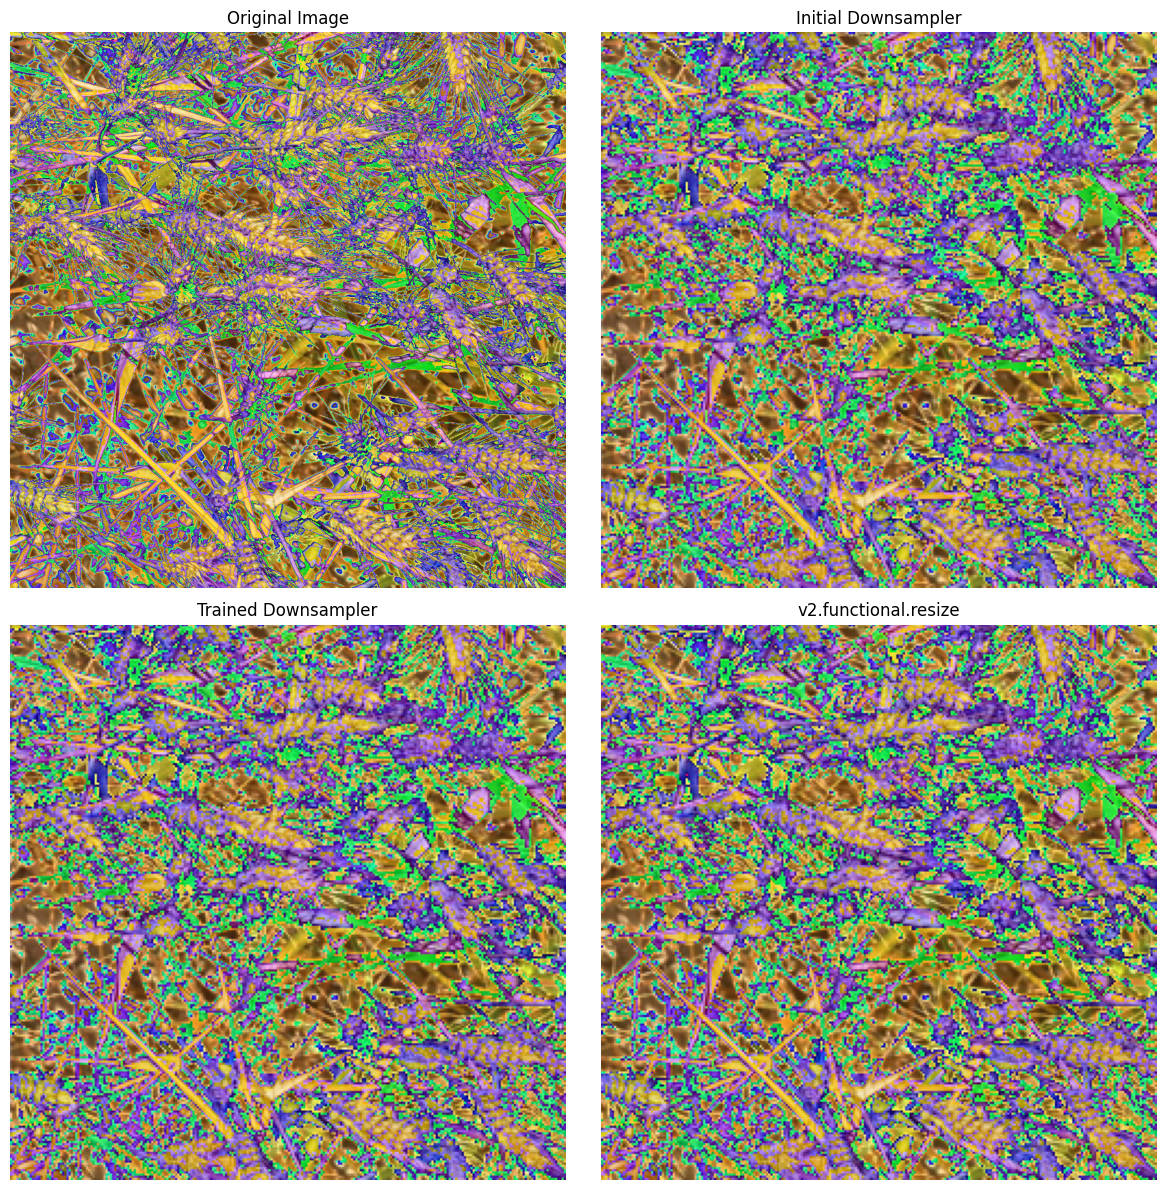

In [15]:
# compare conv_downsampler.pth and initial_conv_downsampler.pth and v2.functional.resize
img_path = "global_wheat_detection/train/00333207f.jpg"
image = Image.open(img_path).convert("RGB")
image = F.to_tensor(image)
image = F.normalize(image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

# Load the initial downsampler model
initial_downsampler = ConvDownsampler256(input_channels=3, output_channels=3)
initial_downsampler.load_state_dict(torch.load("conv_downsampled/initial_conv_downsampler.pth"))
initial_downsampler.eval()

# Load the trained downsampler model
trained_downsampler = ConvDownsampler256(input_channels=3, output_channels=3)
trained_downsampler.load_state_dict(torch.load(os.path.join(model_dir, "conv_downsampler.pth")))
trained_downsampler.eval()

# Apply the initial downsampler
initial_downsampled_image = initial_downsampler(image.unsqueeze(0)).squeeze(0)

# Apply the trained downsampler
trained_downsampled_image = trained_downsampler(image.unsqueeze(0)).squeeze(0)

# Resize the image using v2.functional.resize
resized_image = v2.functional.resize(image, (256, 256))

# Plot the images and the original image in a 2x2 grid (4 images)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(F.to_pil_image(image))
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(F.to_pil_image(initial_downsampled_image))
plt.title("Initial Downsampler")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(F.to_pil_image(trained_downsampled_image))
plt.title("Trained Downsampler")
plt.axis("off")

plt.subplot(2, 2, 4)    
plt.imshow(F.to_pil_image(resized_image))
plt.title("v2.functional.resize")
plt.axis("off")

plt.tight_layout()
plt.show()

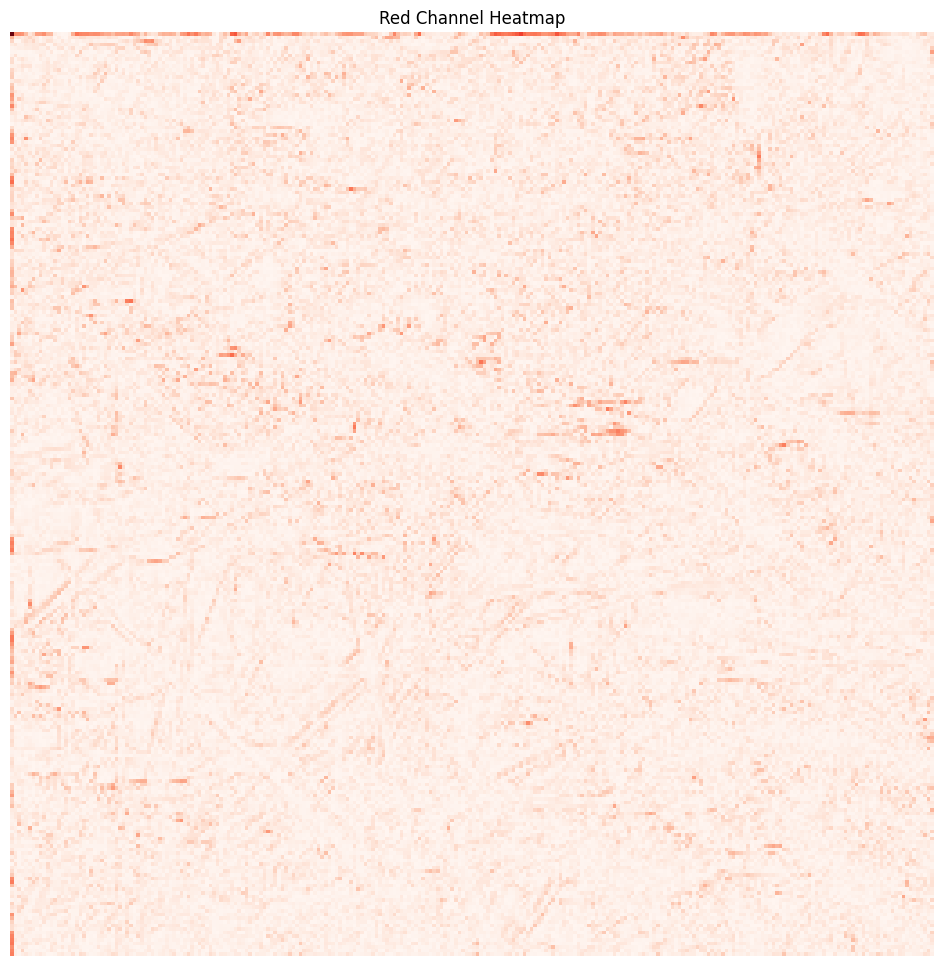

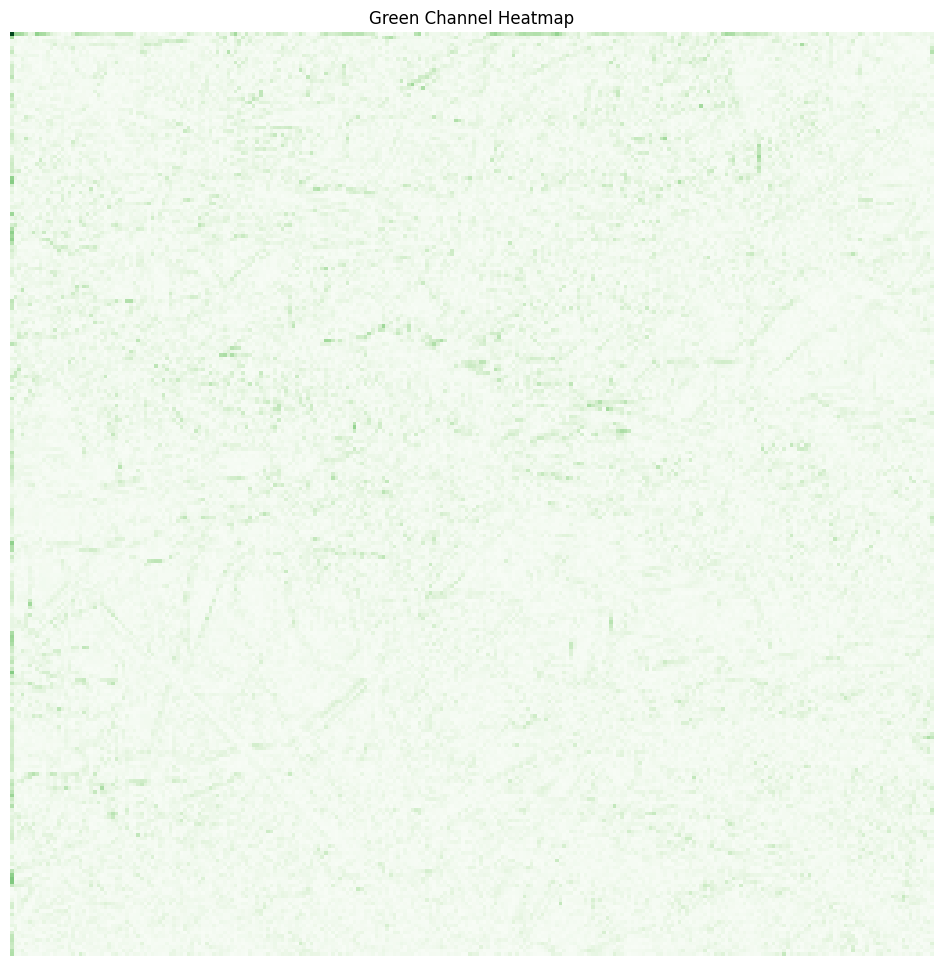

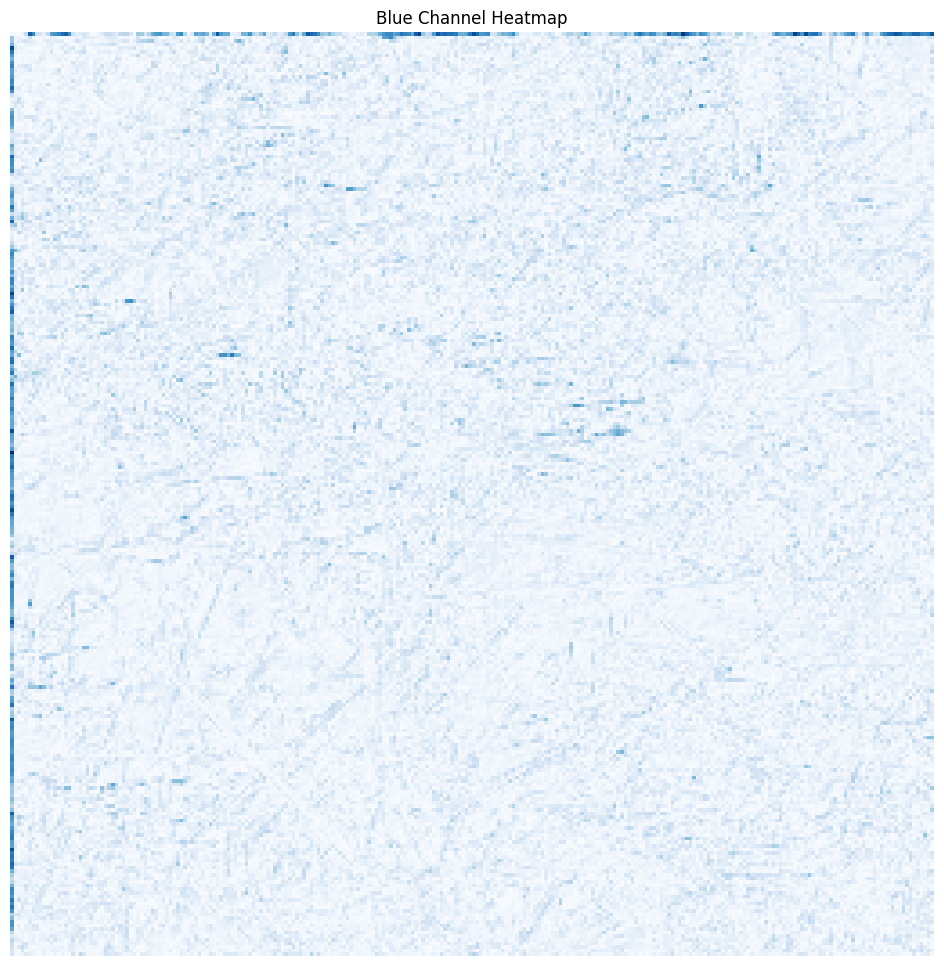

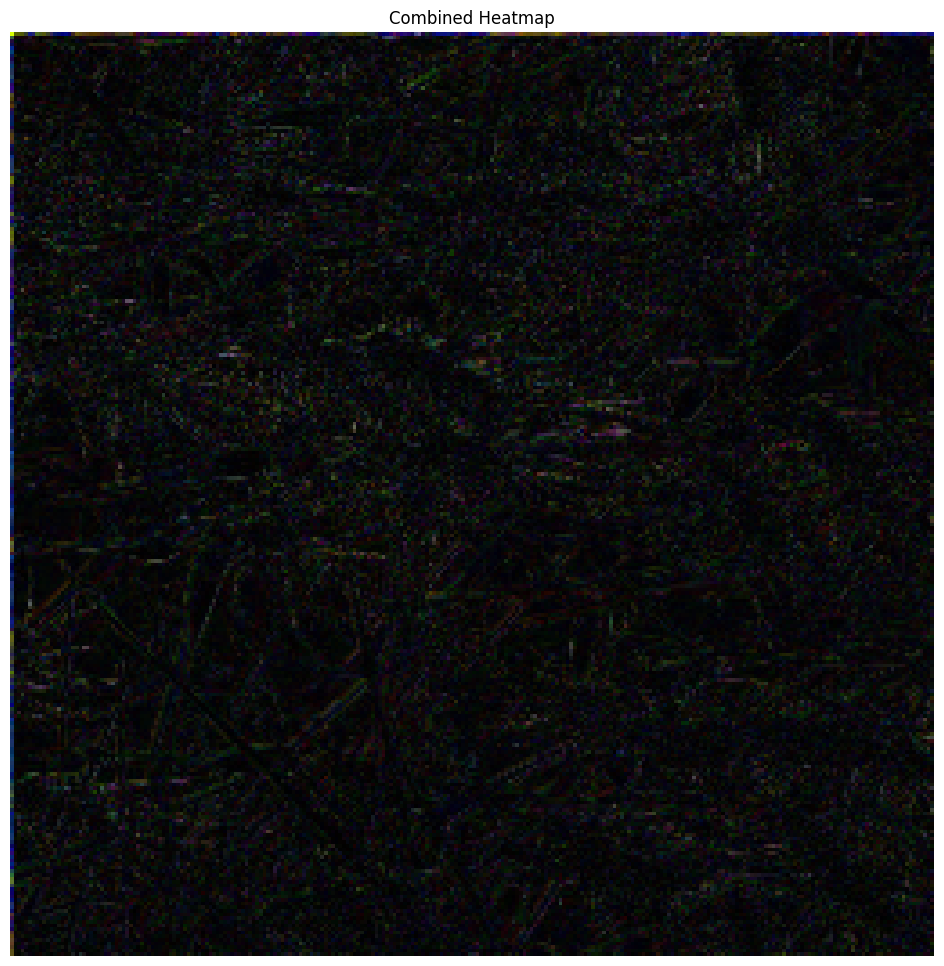

In [16]:
# calculate the difference for each pixel in each channel by subtracting the trained downsampler output from the v2.functional.resize output and taking the absolute value
# create 3 heatmaps from the 3 channels
diff_heatmap = torch.abs(trained_downsampled_image - resized_image)
diff_heatmap = diff_heatmap / diff_heatmap.max()

r_heatmap_tensor = diff_heatmap[0]
g_heatmap_tensor = diff_heatmap[1]
b_heatmap_tensor = diff_heatmap[2]
# overlay the heatmaps on the v2.functional.resize output
resized_image_pil = F.to_pil_image(resized_image)
r_heatmap = F.to_pil_image(r_heatmap_tensor)
g_heatmap = F.to_pil_image(g_heatmap_tensor)
b_heatmap = F.to_pil_image(b_heatmap_tensor)

# plot the heatmaps overlayed on the v2.functional.resize output with multiple plots (one for each channel)
plt.figure(figsize=(12, 12))
plt.imshow(r_heatmap, cmap="Reds")
plt.axis("off")
plt.title("Red Channel Heatmap")
plt.show()

plt.figure(figsize=(12, 12))
plt.imshow(g_heatmap, cmap="Greens")
plt.axis("off")
plt.title("Green Channel Heatmap")
plt.show()

plt.figure(figsize=(12, 12))
plt.imshow(b_heatmap, cmap="Blues")
plt.axis("off")
plt.title("Blue Channel Heatmap")
plt.show()

plt.figure(figsize=(12, 12))
plt.imshow(F.to_pil_image(diff_heatmap))
plt.axis("off")
plt.title("Combined Heatmap")
plt.show()

When looking at the differences between the resized and the output of the downsampler output, I can see some of the edges of the wheat stalks. This is signalling to me, that the downsampler is keeping more of the task specific information than a simple downsizing.

<Axes: xlabel='epoch'>

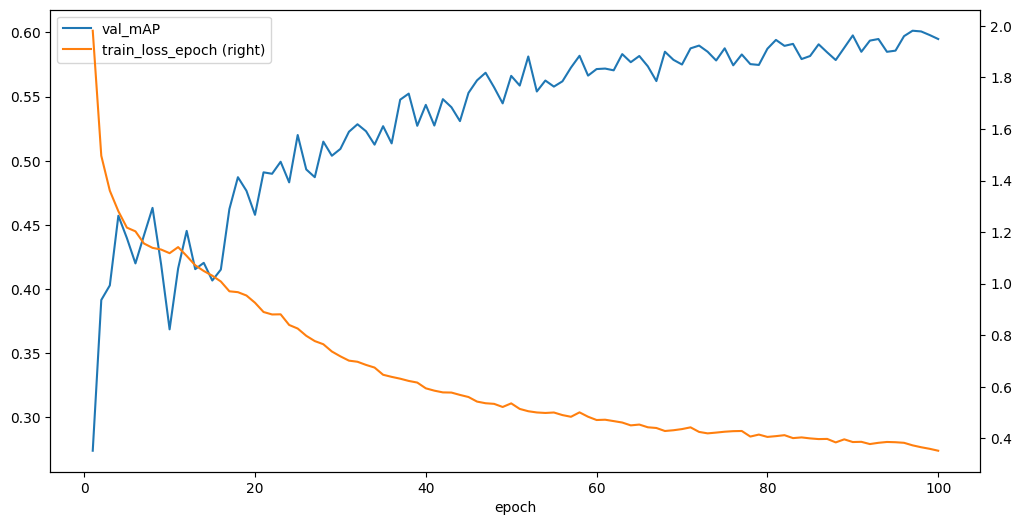

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
log_path = "logs/fasterrcnn-resnet101/version_0/metrics.csv"

# Load the metrics CSV file
metrics_df = pd.read_csv(log_path)
val_ap_df = metrics_df[["epoch", "val_mAP"]]
val_ap_df = val_ap_df.dropna()
train_loss_df = metrics_df[["epoch", "train_loss_epoch"]]
train_loss_df = train_loss_df.dropna()
# merge the dataframes at epoch
merged_df = pd.merge(val_ap_df, train_loss_df, on="epoch")

# Plot the validation mAP and training loss in a single plot
merged_df['epoch'] = merged_df['epoch'] + 1

merged_df.plot(x="epoch", y=["val_mAP", "train_loss_epoch"], secondary_y="train_loss_epoch", figsize=(12, 6))

The model performed quite well with the val_mAP of almost 0.6, but it did not reach the same value as the ViT model, that was pretrained on the plantnet-300k dataset. 